In [ ]:
# First we import libararies
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_path = "/kaggle/input/brisc2025/brisc2025/classification_task/train"
base_path2 = "/kaggle/input/brisc2025/brisc2025/classification_task/test"

In [ ]:
classes = os.listdir(base_path)
print("Classes:", classes)

Classes: ['pituitary', 'no_tumor', 'meningioma', 'glioma']


Number of images per class: {'pituitary': 1457, 'no_tumor': 1067, 'meningioma': 1329, 'glioma': 1147}


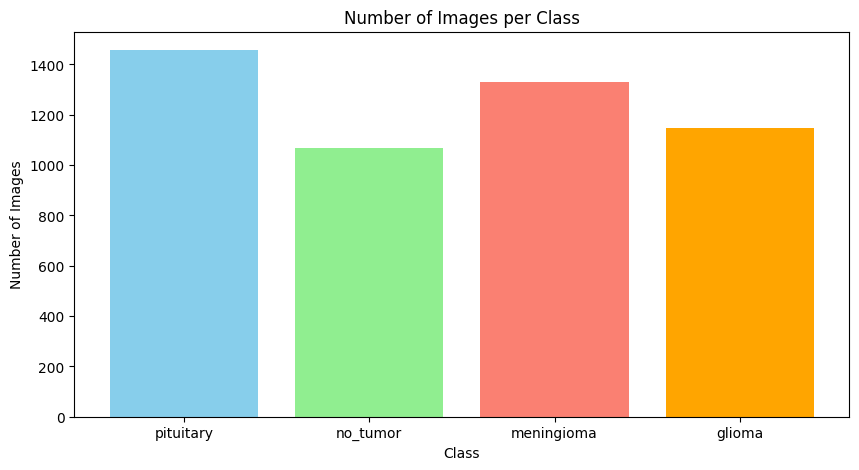

In [ ]:
#distrubution of data
counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in classes}
print("Number of images per class:", counts)
plt.figure(figsize=(10,5))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

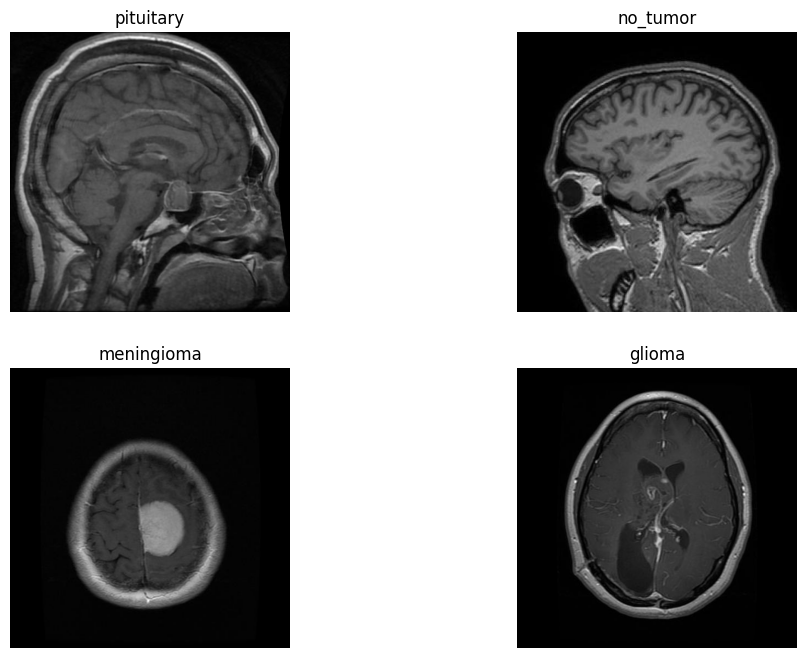

In [ ]:
#random sample show
random.seed(24)
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(base_path, cls)))
    img_path = os.path.join(base_path, cls, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.show()

In [ ]:
#dimensions analysis
shapes = []
for cls in classes:
    for img_name in os.listdir(os.path.join(base_path, cls))[:100]:
        img_path = os.path.join(base_path, cls, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            shapes.append(img.shape[:2])

shapes = np.array(shapes)
print("Average image size (H, W):", shapes.mean(axis=0))
print("Most common image sizes:", Counter([tuple(s) for s in shapes]).most_common(5))


Average image size (H, W): [482.5475 468.4025]
Most common image sizes: [((512, 512), 316), ((369, 216), 32), ((369, 369), 29), ((256, 256), 3), ((369, 210), 2)]


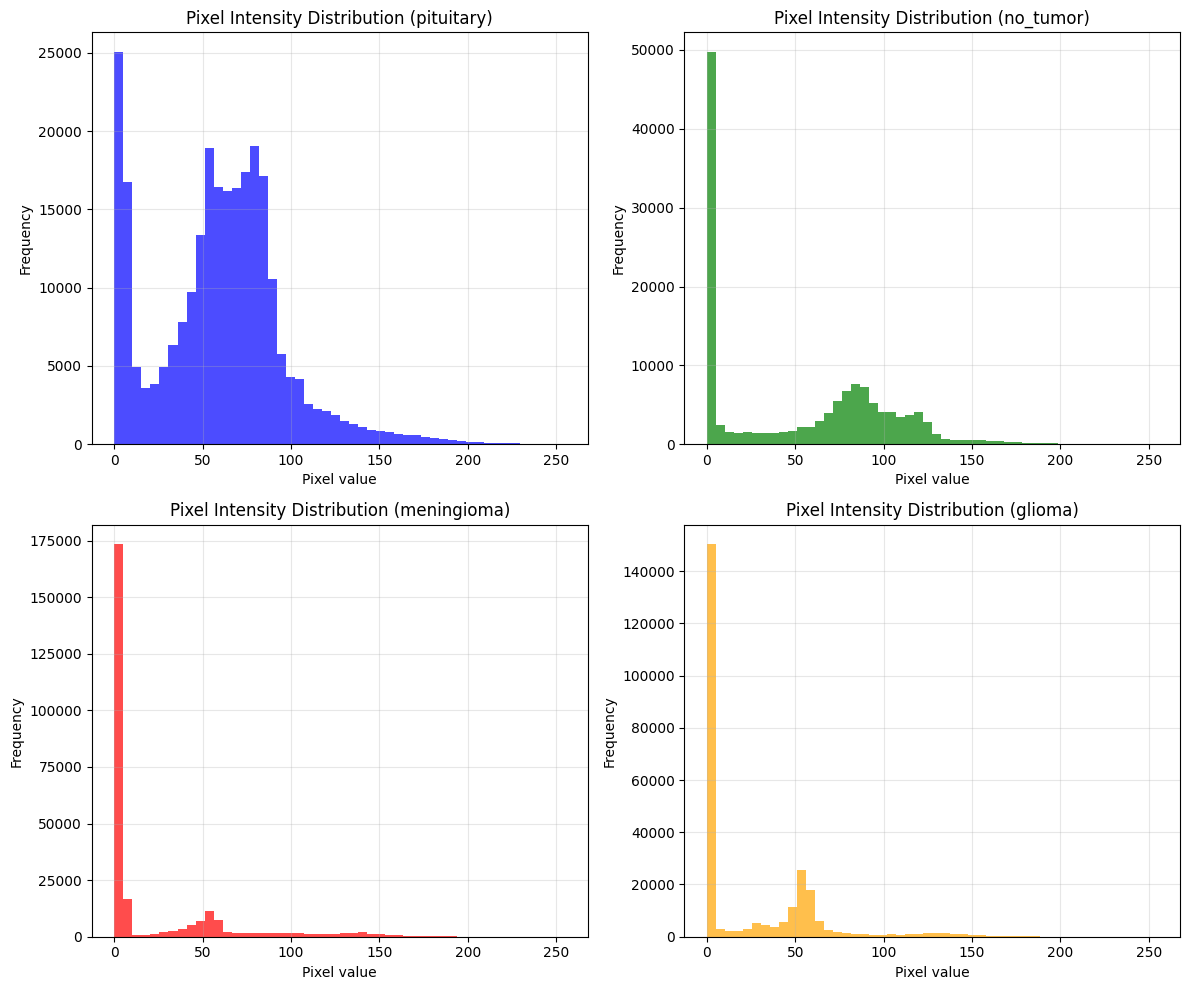

In [ ]:
# Pixel intensity distribution for all classes
random.seed(24)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

colors = ['blue', 'green', 'red', 'orange']

for i, cls in enumerate(classes):
    sample_img_name = random.choice(os.listdir(os.path.join(base_path, cls)))
    sample_img_path = os.path.join(base_path, cls, sample_img_name)

    img = cv2.imread(sample_img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    axes[i].hist(img_gray.ravel(), bins=50, color=colors[i], alpha=0.7)
    axes[i].set_title(f"Pixel Intensity Distribution ({cls})")
    axes[i].set_xlabel("Pixel value")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Detailed statistics for each class
pixel_stats = {}

for cls in classes:
    class_path = os.path.join(base_path, cls)
    all_pixels = []

    for img_name in os.listdir(class_path)[:20]:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            all_pixels.extend(img_gray.ravel())

    if all_pixels:
        pixel_stats[cls] = {
            'mean': np.mean(all_pixels),
            'std': np.std(all_pixels),
            'min': np.min(all_pixels),
            'max': np.max(all_pixels),
            'median': np.median(all_pixels)
        }

print("Pixel Intensity Statistics per Class:")
print("="*50)  # Separator line
for cls, stats in pixel_stats.items():
    print(f"{cls:12} | Mean: {stats['mean']:6.2f} | Std: {stats['std']:6.2f} | "
          f"Range: [{stats['min']:3d}, {stats['max']:3d}]")

Pixel Intensity Statistics per Class:
pituitary    | Mean:  48.48 | Std:  41.92 | Range: [  0, 255]
no_tumor     | Mean:  51.64 | Std:  56.02 | Range: [  0, 255]
meningioma   | Mean:  38.79 | Std:  45.50 | Range: [  0, 255]
glioma       | Mean:  36.46 | Std:  40.67 | Range: [  0, 255]


In [ ]:
#check on null images
bad_images = []
for cls in classes:
    for img_name in os.listdir(os.path.join(base_path, cls)):
        img_path = os.path.join(base_path, cls, img_name)
        img = cv2.imread(img_path)
        if img is None or img.size == 0:
            bad_images.append(img_path)

print("Number of bad images:", len(bad_images))
if bad_images:
    print("Examples of bad images:", bad_images[:5])


Number of bad images: 0


In [ ]:
#function to resize images to 256x256
def resize_image(img, target_size=(256, 256)):
    return cv2.resize(img, target_size)

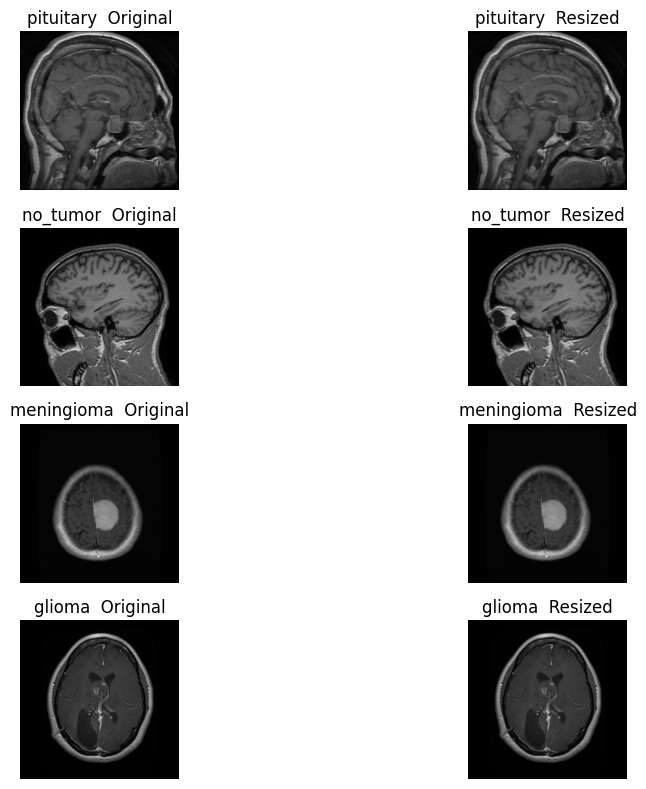

In [ ]:
#see what happens after resize
random.seed(24)
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(base_path, cls)))
    img_path = os.path.join(base_path, cls, img_name)
    img = cv2.imread(img_path)
    img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = resize_image(img, target_size=(256, 256))


    plt.subplot(len(classes), 2, 2*i + 1)
    plt.imshow(img_original)
    plt.title(f"{cls}  Original")
    plt.axis("off")


    plt.subplot(len(classes), 2, 2*i + 2)
    plt.imshow(img_resized)
    plt.title(f"{cls}  Resized")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#function to normalize data using min max
def normalize_image(img):
    return img.astype("float32") / 255.0

In [ ]:
#function to applay histogram equalization using CLAHE
def enhance_contrast(img):
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_enhanced = clahe.apply(img_gray)
    return cv2.cvtColor(img_enhanced, cv2.COLOR_GRAY2RGB)

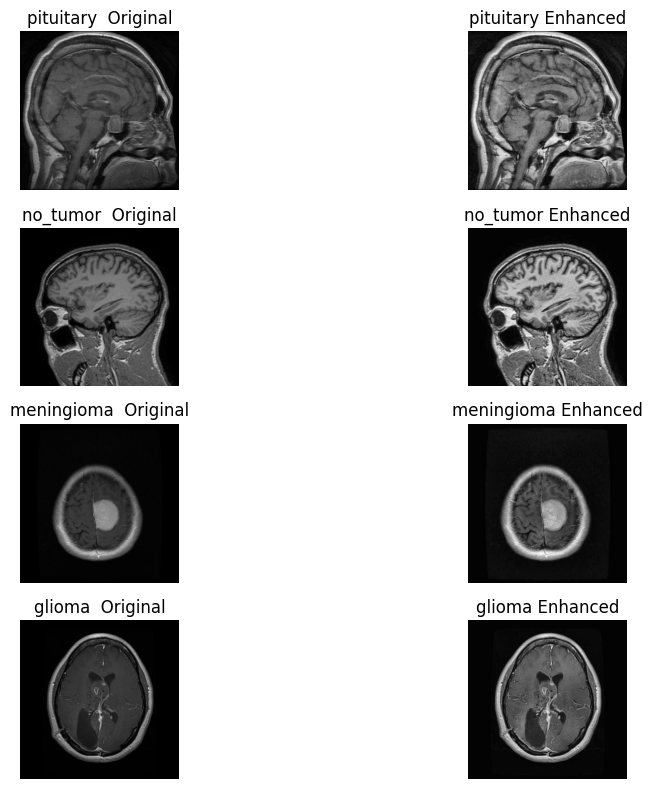

In [ ]:
#see what happens after histogram equalization
random.seed(24)
plt.figure(figsize=(12, 8))

for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(base_path, cls)))
    img_path = os.path.join(base_path, cls, img_name)

    img = cv2.imread(img_path)
    img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_processed = enhance_contrast(img_original)

    plt.subplot(len(classes), 2, 2*i + 1)
    plt.imshow(img_original)
    plt.title(f"{cls}  Original")
    plt.axis("off")

    plt.subplot(len(classes), 2, 2*i + 2)
    plt.imshow(img_processed)
    plt.title(f"{cls} Enhanced")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
#define the augmentation we want
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
#funtion on one image
def augment_image(img):
    img = np.expand_dims(img, axis=0)
    it = datagen.flow(img, batch_size=1)
    return next(it)[0].astype("float32")

In [ ]:
#the balancing function using augmentation if needed
def balance_with_augmentation(X, y, class_names, target_size=(256,256)):
    counts = Counter(y)
    max_count = max(counts.values())

    X_balanced, y_balanced = list(X), list(y)

    for class_idx, class_name in enumerate(class_names):
        deficit = max_count - counts[class_idx]
        if deficit > 0:
            print(f"Augmenting class {class_name} with {deficit} new samples...")
            class_imgs = [img for img, label in zip(X, y) if label == class_idx]

            for i in range(deficit):
                img = random.choice(class_imgs)
                aug_img = augment_image(img)
                X_balanced.append(aug_img)
                y_balanced.append(class_idx)

    return np.array(X_balanced), np.array(y_balanced)

In [ ]:
#function of preprocceing pipline which is resize,denoise,enhance,normalize
def preprocess_pipeline(img, target_size=(256, 256), augment=False):
    img = resize_image(img, target_size)
    img = enhance_contrast(img)
    img = normalize_image(img)

    if augment:
        img = augment_image(img)

    return img


In [ ]:
#function to load and applay pipeline
def load_and_preprocess_dataset(base_path, target_size=(256,256), augment=False, save_to=None):
    X, y = [], []
    class_names = os.listdir(base_path)

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(base_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        print(f"Processing class: {class_name}")
        for file in tqdm(os.listdir(class_dir)):
            file_path = os.path.join(class_dir, file)
            img = cv2.imread(file_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_pipeline(img, target_size=target_size, augment=augment)

            X.append(img)
            y.append(class_idx)

            if save_to:
                save_class_dir = os.path.join(save_to, class_name)
                os.makedirs(save_class_dir, exist_ok=True)
                save_path = os.path.join(save_class_dir, file)
                cv2.imwrite(save_path, cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    return np.array(X), np.array(y), class_names

In [ ]:
#applay the functions
X, y, class_names = load_and_preprocess_dataset(
    base_path=base_path,
    target_size=(256,256),
    augment=False,
    save_to="./processed"
)
X2, y2, class_names2 = load_and_preprocess_dataset(
    base_path=base_path2,
    target_size=(256,256),
    augment=False,
    save_to="./processed2"
)

print("Dataset shape:", X.shape, y.shape)
print("Classes:", class_names)
print("Dataset shape:", X2.shape, y2.shape)
print("Classes:", class_names2)

Processing class: pituitary


100%|██████████| 1457/1457 [00:08<00:00, 177.51it/s]


Processing class: no_tumor


100%|██████████| 1067/1067 [00:05<00:00, 191.42it/s]


Processing class: meningioma


100%|██████████| 1329/1329 [00:07<00:00, 182.45it/s]


Processing class: glioma


100%|██████████| 1147/1147 [00:06<00:00, 183.11it/s]


Processing class: pituitary


100%|██████████| 300/300 [00:03<00:00, 82.56it/s]


Processing class: no_tumor


100%|██████████| 140/140 [00:01<00:00, 90.89it/s]


Processing class: meningioma


100%|██████████| 306/306 [00:03<00:00, 82.04it/s]


Processing class: glioma


100%|██████████| 254/254 [00:03<00:00, 82.03it/s]


Dataset shape: (5000, 256, 256, 3) (5000,)
Classes: ['pituitary', 'no_tumor', 'meningioma', 'glioma']
Dataset shape: (1000, 256, 256, 3) (1000,)
Classes: ['pituitary', 'no_tumor', 'meningioma', 'glioma']


In [ ]:
#  Balance Dataset using Augmentation
X, y = balance_with_augmentation(X, y, class_names)
print("Balanced dataset shape:", X.shape, y.shape)

from collections import Counter
print("Class distribution after balancing:", Counter(y))


Augmenting class no_tumor with 390 new samples...
Augmenting class meningioma with 128 new samples...
Augmenting class glioma with 310 new samples...
Balanced dataset shape: (5828, 256, 256, 3) (5828,)
Class distribution after balancing: Counter({0: 1457, 1: 1457, 2: 1457, 3: 1457})


In [ ]:
# One-hot encode labels
y = to_categorical(y, num_classes=len(class_names))
y2 = to_categorical(y2, num_classes=len(class_names2))

In [ ]:
X_train = np.array([cv2.resize(img, (224,224)) for img in X])
X_val  = np.array([cv2.resize(img, (224,224)) for img in X2])

In [ ]:
def build_model(num_classes, dropout_rate=0.4, l2_reg=1e-4, lr=1e-3):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    inputs = layers.Input(shape=(224,224,3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax",
                           kernel_regularizer=regularizers.l2(l2_reg))(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model, base_model

In [ ]:
mc = ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model, base_model = build_model(num_classes=len(class_names))
history = model.fit(
    X_train, y,
    validation_data=(X_val, y2),
    epochs=10,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)

I0000 00:00:1766050658.681618      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


I0000 00:00:1766050683.158068     105 service.cc:148] XLA service 0x7c99b814eaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766050683.158664     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766050684.563021     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/183 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2559 - loss: 1.6254 

I0000 00:00:1766050688.378907     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2984 - loss: 1.4602
Epoch 1: val_loss improved from inf to 1.30670, saving model to best_model.h5
183/183 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.2987 - loss: 1.4597 - val_accuracy: 0.4630 - val_loss: 1.3067
Epoch 2/10
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4621 - loss: 1.2298
Epoch 2: val_loss improved from 1.30670 to 1.14900, saving model to best_model.h5
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.4622 - loss: 1.2296 - val_accuracy: 0.5450 - val_loss: 1.1490
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5199 - loss: 1.1403
Epoch 3: val_loss improved from 1.14900 to 1.12798, saving model to best_model.h5
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5199 - loss: 1.1402 - val_accuracy: 0.5650 - val_loss: 1.1280
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5473 - loss: 1.1125
Epoch 4: val_loss improved from 1.12798 to 1.09326, saving mode

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    X_train, y,
    validation_data=(X_val, y2),
    epochs=15,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5495 - loss: 2.7530
Epoch 1: val_loss did not improve from 0.99810
183/183 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.5499 - loss: 2.7463 - val_accuracy: 0.3960 - val_loss: 2.3068
Epoch 2/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7752 - loss: 0.6215
Epoch 2: val_loss improved from 0.99810 to 0.49220, saving model to best_model.h5
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.7754 - loss: 0.6210 - val_accuracy: 0.7950 - val_loss: 0.4922
Epoch 3/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8312 - loss: 0.4330
Epoch 3: val_loss improved from 0.49220 to 0.38203, saving model to best_model.h5
183/183 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.8313 - loss: 0.4328 - val_accuracy: 0.8540 - val_loss: 0.3820
Epoch 4/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8653 - loss: 0.3568
Epoch 4: val_loss improved from 0.38203 to 0.32379, saving model to best_model.h5


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,910 (90.01 MB)

 Trainable params: 16,958,724 (64.69 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 2 (12.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9685 - loss: 0.1174
 Validation Loss: 0.2053
 Validation Accuracy: 0.9390
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step

 Classification Report:

              precision    recall  f1-score   support

   pituitary       0.98      0.99      0.99       300
    no_tumor       0.95      0.99      0.97       140
  meningioma       0.94      0.88      0.91       306
      glioma       0.89      0.93      0.91       254

    accuracy                           0.94      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.94      0.94      0.94      1000



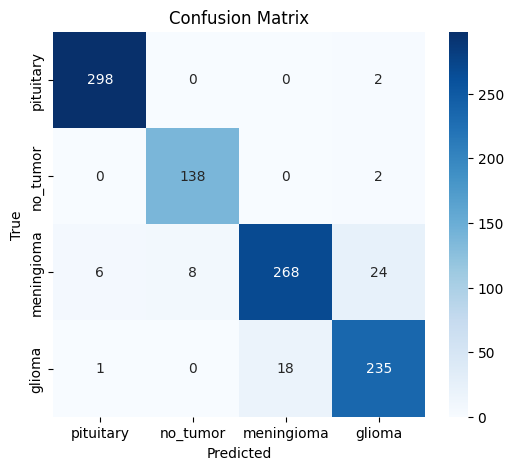

In [ ]:
# Final evaluation for testing
val_loss, val_acc = model.evaluate(X_val, y2, verbose=1)
print(f" Validation Loss: {val_loss:.4f}")
print(f" Validation Accuracy: {val_acc:.4f}")

# Classification report & Confusion Matrix
y_pred = model.predict(X_val)
y_true = np.argmax(y2, axis=1)
y_pred = np.argmax(y_pred, axis=1)

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names2))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names2, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

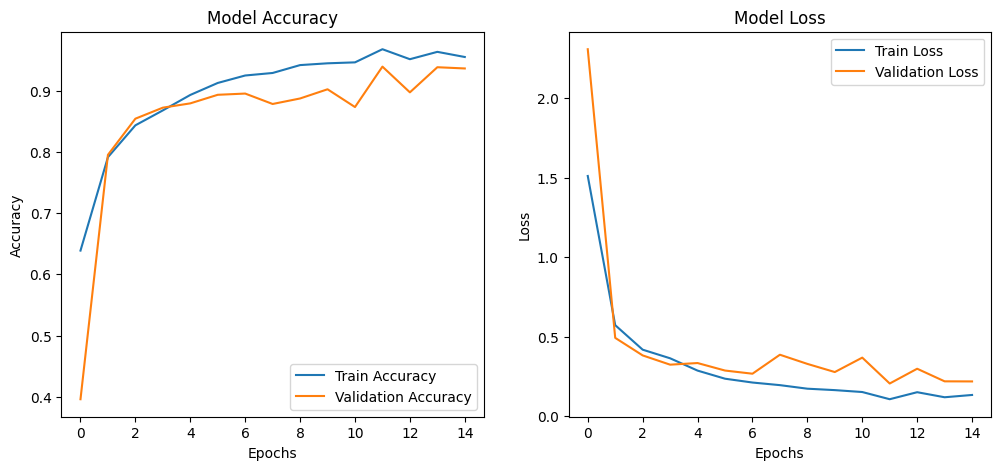

In [ ]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


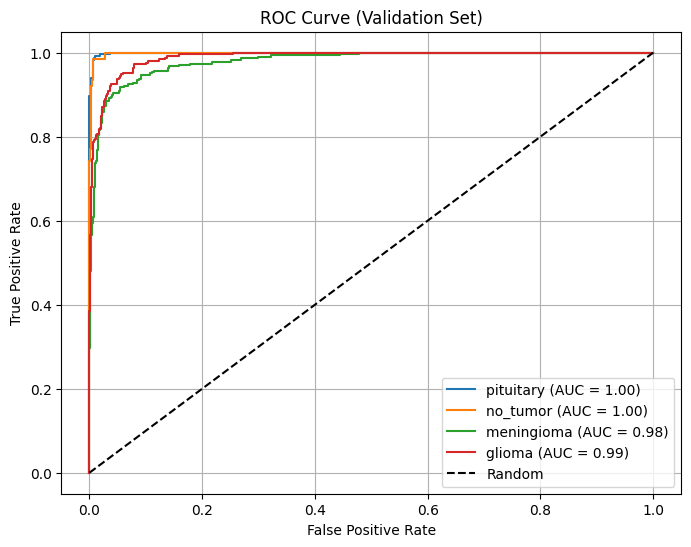

AUC for each class:

pituitary: 0.9994
no_tumor: 0.9987
meningioma: 0.9797
glioma: 0.9888
Macro Average AUC: 0.9916


In [ ]:
y_true_onehot = y2
y_pred_prob = model.predict(X_val)
n_classes = 4

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f'{class_names2[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

print("AUC for each class:\n")
for i in range(n_classes):
    print(f"{class_names2[i]}: {roc_auc[i]:.4f}")
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro Average AUC: {macro_auc:.4f}")


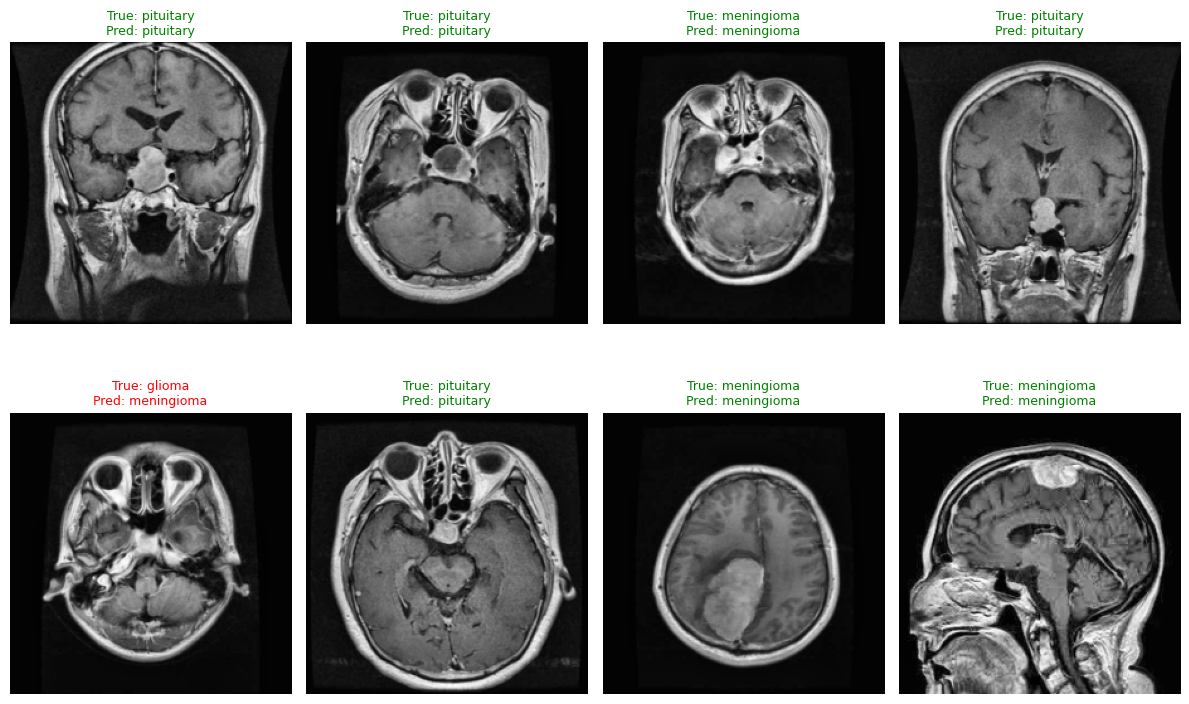

In [ ]:
# Sample predictions visualization
plt.figure(figsize=(12, 8))
for i, idx in enumerate(np.random.choice(len(X_val), 8, replace=False)):
    plt.subplot(2, 4, i+1)
    plt.imshow((X_val[idx] * 255).astype("uint8"))
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()